In [166]:

import scipy
import math
import warnings

## from IPython.display import displayomm
from matplotlib import pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns
from sklearn import linear_model

from sklearn import preprocessing
import statsmodels.formula.api as smf

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


## Downloading the file thru python for the ease to reproduce.

import requests
import zipfile
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)
%matplotlib inline

## KNN Regression Vs. Linear Regression

In this challenge, I will explore The same Data that was used by Billy Beane and Paul Depodesta or more famously known as Brad Pitt and Jonah Hill respectivly. 

I will use KNN regression and validate the scores and compare them with the Linear Regression model. 

Let's Take a look at the Data first.

For more info on the Data visit : https://www.kaggle.com/wduckett/moneyball-mlb-stats-19622012/home


In [188]:
## importing the data from the directory.

data_path = ('./moneyball.zip')

df_raw = pd.read_csv(data_path, )

In [197]:
df_raw1 = df_raw.dropna().copy()

In [198]:
df_raw1.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.000,5.000,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.000,4.000,162,0.315,0.403
6,CIN,NL,2012,669,588,97,0.315,0.411,0.251,1,2.000,4.000,162,0.305,0.390
9,DET,AL,2012,726,670,88,0.335,0.422,0.268,1,6.000,2.000,162,0.314,0.402
18,NYY,AL,2012,804,668,95,0.337,0.453,0.265,1,3.000,3.000,162,0.311,0.419


In [199]:
df_raw1.drop(['Year', 'Playoffs'], axis = 1).describe()

,RS,RA,W,OBP,SLG,BA,RankSeason,RankPlayoffs,G,OOBP,OSLG
count,114.000,114.000,114.000,114.000,114.000,114.000,114.000,114.000,114.000,114.000,114.000
mean,812.851,697.439,94.482,0.341,0.434,0.269,3.649,3.158,161.974,0.321,0.404
std,74.074,63.509,4.892,0.013,0.021,0.011,1.839,1.077,0.363,0.011,0.019
min,669.000,529.000,82.000,0.310,0.389,0.238,1.000,1.000,161.000,0.296,0.361
25%,761.250,650.250,91.000,0.332,0.420,0.262,2.000,3.000,162.000,0.314,0.392
50%,804.500,689.500,95.000,0.341,0.433,0.269,4.000,4.000,162.000,0.321,0.403
75%,865.250,733.500,97.000,0.350,0.448,0.277,5.000,4.000,162.000,0.328,0.417
max,1009.000,860.000,116.000,0.373,0.491,0.293,7.000,5.000,163.000,0.348,0.459


In [200]:
df_raw1.dtypes

Team             object
League           object
Year              int64
RS                int64
RA                int64
W                 int64
OBP             float64
SLG             float64
BA              float64
Playoffs          int64
RankSeason      float64
RankPlayoffs    float64
G                 int64
OOBP            float64
OSLG            float64
dtype: object

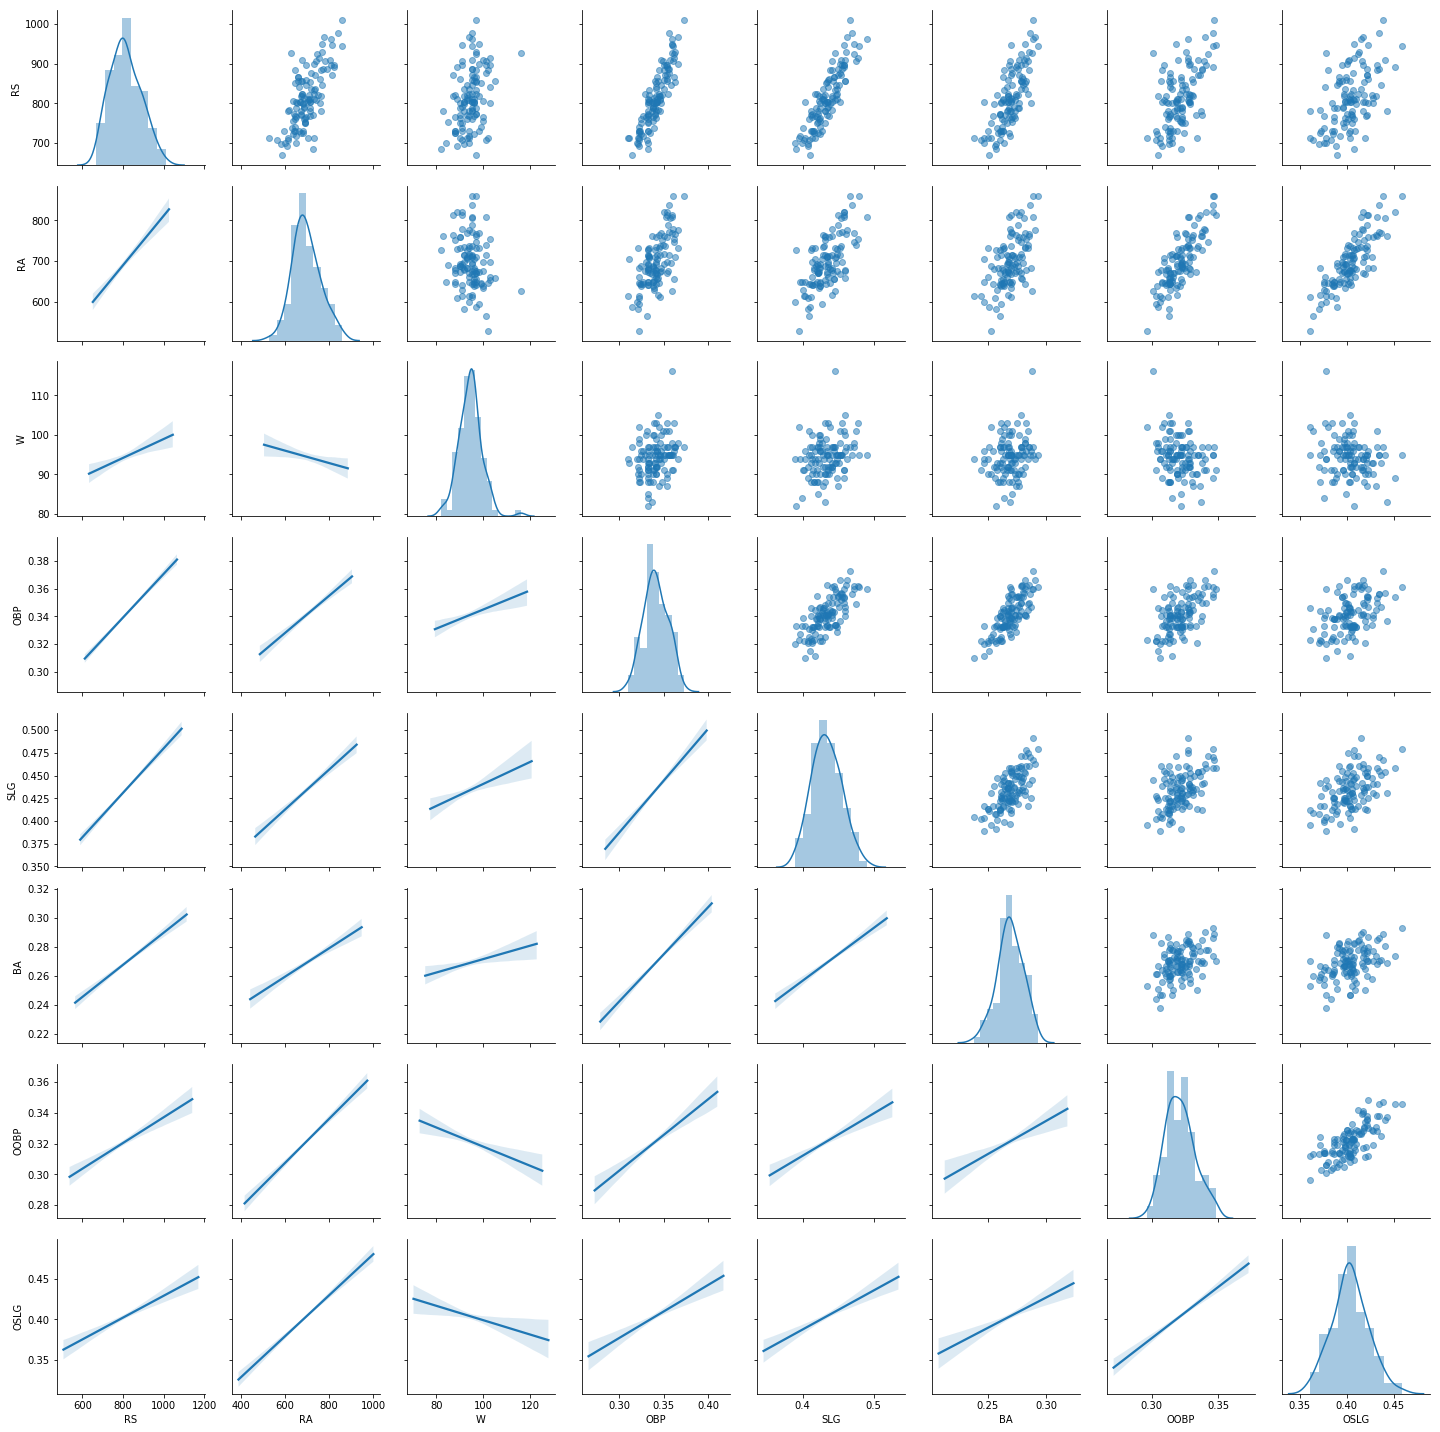

In [202]:
## Creating  a Pair grid and adding jitter to show more details in the scatter plot part of the plot.
dfPlot =  df_raw1.drop(['Year', 'Team', 'League', 
                        'RankSeason','RankPlayoffs', 'Playoffs', 'G'], axis = 1).copy()
jitter = pd.DataFrame(
    np.random.uniform(-.1, .1, size=(dfPlot.shape)),
    columns=dfPlot.columns)
##dfPlot = dfPlot.add(jitter)

g = sns.PairGrid(dfPlot, diag_sharey=False)


# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.distplot)
plt.show()

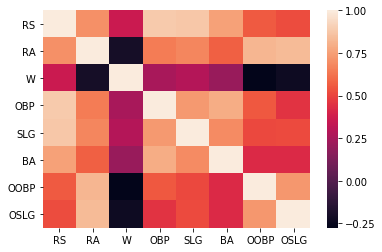

In [203]:
sns.heatmap(dfPlot.corr())

In [208]:
dfPlot.describe()

,RS,RA,W,OBP,SLG,BA,OOBP,OSLG
count,114.000,114.000,114.000,114.000,114.000,114.000,114.000,114.000
mean,812.851,697.439,94.482,0.341,0.434,0.269,0.321,0.404
std,74.074,63.509,4.892,0.013,0.021,0.011,0.011,0.019
min,669.000,529.000,82.000,0.310,0.389,0.238,0.296,0.361
25%,761.250,650.250,91.000,0.332,0.420,0.262,0.314,0.392
50%,804.500,689.500,95.000,0.341,0.433,0.269,0.321,0.403
75%,865.250,733.500,97.000,0.350,0.448,0.277,0.328,0.417
max,1009.000,860.000,116.000,0.373,0.491,0.293,0.348,0.459


So Now that we have explored the data in a breif way. the next part will be for the modelling of KNN regression and Linear Regression

## Modeling 

We will start by modeling the KNN regression. The model will try to predict Runs Scored (RS) by using the other features or some of them until we get a good prediction. From the Correlation matrix there seems to be some columns that are heavily correlated and We will only use one in our model and it will be the variable that we are trying to predict. 

In [212]:
## in this part we will normalize the data ot deal with the different rates and distances. 

dfPlot1 = pd.DataFrame(preprocessing.normalize(dfPlot ,  axis = 0), columns = dfPlot.columns)

dfPlot1.describe()

,RS,RA,W,OBP,SLG,BA,OOBP,OSLG
count,114.000,114.000,114.000,114.000,114.000,114.000,114.000,114.000
mean,0.093,0.093,0.094,0.094,0.094,0.094,0.094,0.094
std,0.009,0.008,0.005,0.004,0.004,0.004,0.003,0.004
min,0.077,0.071,0.081,0.085,0.084,0.083,0.086,0.084
25%,0.087,0.087,0.090,0.091,0.091,0.091,0.091,0.091
50%,0.092,0.092,0.094,0.094,0.093,0.094,0.093,0.093
75%,0.099,0.098,0.096,0.096,0.097,0.096,0.096,0.097
max,0.116,0.115,0.115,0.102,0.106,0.102,0.101,0.106


In [211]:
pd.DataFrame(preprocessing.normalize(dfPlot ,  axis = 0)).head()

,0,1,2,3,4,5,6,7
0,0.080,0.080,0.093,0.088,0.084,0.086,0.089,0.088
1,0.082,0.094,0.092,0.085,0.090,0.086,0.092,0.093
2,0.077,0.079,0.096,0.086,0.089,0.087,0.089,0.090
3,0.083,0.090,0.087,0.092,0.091,0.093,0.091,0.093
4,0.092,0.089,0.094,0.092,0.098,0.092,0.091,0.097


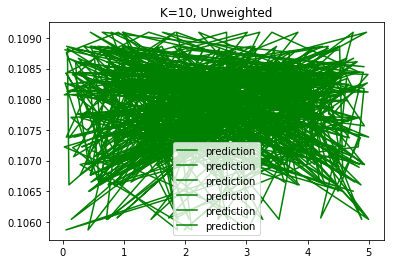

In [330]:
# from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(dfPlot1.iloc[:, 2:])
Y = dfPlot1.RS
knn.fit(X, Y)

# Set up our prediction line.
#T = np.linspace(0, 5, 500)[:, np.newaxis]

T = pd.DataFrame(data = np.random.uniform(0, 5, size=(X.shape)), columns = X.columns)
Y_ = knn.predict(T)
# Trailing underscores are a common convention for a prediction.
#Y_ = knn.predict(T)
##plt.figure(figsize=(20,20))
##plt.scatter(X, Y, c='k', label='data')
##plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()



In [331]:
from sklearn.model_selection import cross_val_score


Weighted Accuracy: 0.73 (+/- 0.34)


In [357]:
# from sklearn import neighbors

# Build our model but this time with weights taken into consideration.

# in order to get more resutls this time I will create a function that picks different weights and shows its results

X = pd.DataFrame(dfPlot1.iloc[:, 2:])
Y = dfPlot1.RS
scores = []
for i in np.arange(1,15):
    for weights in ['uniform', 'distance']:
            knn_w = neighbors.KNeighborsRegressor(n_neighbors=i,
                                                weights=weights)
            
            knn.fit(X, Y)
            ##T = pd.DataFrame(data = np.random.uniform(0, 5, size=(X.shape)), columns = X.columns)
            score = cross_val_score(knn_w, X, Y, cv=10)
            scores.append("Weighted Accuracy: %0.2f (+/- %0.2f) and the weights is based on %s" % (score.mean(), score.std() * 2, weights))
            scores
scores
##knn_w = neighbors.KNeighborsRegressor(n_neighbors=10)

##knn.fit(X, Y)

# Set up our prediction line.
#T = np.linspace(0, 5, 500)[:, np.newaxis]



['Weighted Accuracy: 0.63 (+/- 0.45) and the weights is based on uniform',
 'Weighted Accuracy: 0.63 (+/- 0.45) and the weights is based on distance',
 'Weighted Accuracy: 0.73 (+/- 0.40) and the weights is based on uniform',
 'Weighted Accuracy: 0.73 (+/- 0.39) and the weights is based on distance',
 'Weighted Accuracy: 0.72 (+/- 0.28) and the weights is based on uniform',
 'Weighted Accuracy: 0.73 (+/- 0.28) and the weights is based on distance',
 'Weighted Accuracy: 0.71 (+/- 0.36) and the weights is based on uniform',
 'Weighted Accuracy: 0.72 (+/- 0.35) and the weights is based on distance',
 'Weighted Accuracy: 0.72 (+/- 0.35) and the weights is based on uniform',
 'Weighted Accuracy: 0.74 (+/- 0.34) and the weights is based on distance',
 'Weighted Accuracy: 0.73 (+/- 0.32) and the weights is based on uniform',
 'Weighted Accuracy: 0.74 (+/- 0.31) and the weights is based on distance',
 'Weighted Accuracy: 0.73 (+/- 0.32) and the weights is based on uniform',
 'Weighted Accuracy

In this part I will use the OLS linear regression and see how it will fair in comparison to the KNN regression 


In [314]:
## I will use smf linear regression to see more details about our outcome
linear_formula = 'RS ~ SLG + OBP+ W + BA  + OOBP + OSLG'
# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=dfPlot1).fit()

In [315]:
lm.params

Intercept   -0.143
SLG          0.781
OBP          1.092
W            0.284
BA           0.015
OOBP         0.210
OSLG         0.144
dtype: float64

In [316]:
lm.rsquared

0.92036768474144282

In [317]:
lm.pvalues

Intercept   0.000
SLG         0.000
OBP         0.000
W           0.000
BA          0.887
OOBP        0.095
OSLG        0.078
dtype: float64

In [319]:
X2 = dfPlot1[['SLG', 'OBP', 'W', 'BA' ,'OOBP' ,'OSLG']]
regr = linear_model.LinearRegression()
from sklearn.model_selection import cross_val_score
score1 = cross_val_score(regr, X2, Y, cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score1.mean(), score1.std() * 2))

Weighted Accuracy: 0.82 (+/- 0.25)


It seems like the linear regression using OLS is more accurate than that of the KNN regression in this part. The data shows a lot of correlation between the different predictors and the target. 